Brian Blaylock  
October 5, 2018

# HRRR Time-lagged Ensembles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553103/')
from BB_HRRR.HRRR_Pando import get_hrrr_variable, get_hrrr_latlon, pluck_hrrr_point
from BB_maps.my_basemap import draw_HRRR_map
from BB_cmap.NWS_standard_cmap import *
from BB_MesoWest.get_MesoWest import get_mesowest_radius, get_network_ids
from BB_MesoWest.get_credentials import get_MW_token

In [6]:
m = draw_HRRR_map()
lat, lon = get_hrrr_latlon(DICT=False)

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
validDATE = datetime(2018, 10, 4, 4)
variable = 'TMP:2 m'
sVAR = variable.replace(':', '-').replace(' ', '-')

if variable == 'TMP:2 m':
    mw_variable = 'air_temp'
    cmap = cm_temp()

HH = np.array([get_hrrr_variable(validDATE - timedelta(hours=f), variable, fxx=f, verbose=False)['value'] for f in range(19)])

if variable.split(':')[0] in ['TMP', 'DPT']:
    HH -= 273.15

In [4]:
forecasts = {0:{'name':'F02 through F05',
                'data':HH[2:6]},
             1:{'name':'F06 through F12',
                'data':HH[6:13]},
             2:{'name':'F12 through F18',
                'data':HH[12:]},
             3:{'name':'F06 through F18',
                'data':HH[6:]},
            }

F00: 0.27278456
F00: 0.33558694
F00: 0.37249494
F00: 0.35393828
F01: 0.17783745
F01: 0.24063973
F01: 0.27754766
F01: 0.25899112


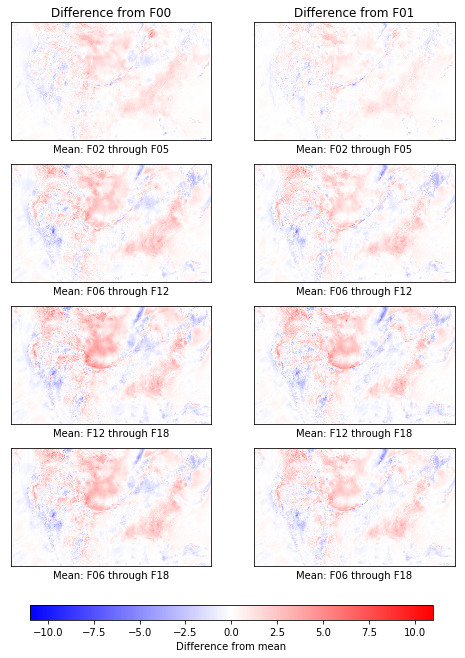

In [55]:
fig, axes = plt.subplots(4,2, figsize=[8,10])

vmax = np.maximum(np.abs((HH[1:] - HH[0]).max()), np.abs((HH[1:] - HH[0]).min()))
vmin = -vmax

# Difference From F00
for i in range(len(forecasts)):
    TLE_mean = np.mean(forecasts[i]['data'], axis=0)
    print('F00:', np.mean(TLE_mean-HH[0]))
    plt.sca(axes[:,[0]][i][0])
    m.pcolormesh(lon, lat, TLE_mean-HH[0], latlon=True, vmax=vmax, vmin=vmin, cmap='bwr')
    plt.xlabel('Mean: %s' % forecasts[i]['name'])

# Difference From F01
for i in range(len(forecasts)):
    TLE_mean = np.mean(forecasts[i]['data'], axis=0)
    print('F01:', np.mean(TLE_mean-HH[1]))
    plt.sca(axes[:,[1]][i][0])
    mesh = m.pcolormesh(lon, lat, TLE_mean-HH[1], latlon=True, vmax=vmax, vmin=vmin, cmap='bwr')
    plt.xlabel('Mean: %s' % forecasts[i]['name'])

# Differnece From Observed
    
#fig.subplots_adjust(bottom=0.8)
cbar_ax = fig.add_axes([0.16, 0.05, 0.7, 0.02]) # [left, bottom, width, height]
cb = fig.colorbar(mesh, cax=cbar_ax, orientation='horizontal')
cb.ax.set_xlabel(r'Difference from mean');

axes[0][0].set_title('Difference from F00');
axes[0][1].set_title('Difference from F01');
#axes[0][1].set_title('Observed');

In [17]:
if variable == 'TMP:2 m':
    mw_variable = 'air_temp'
    cmap = cm_temp()

# MesoWest Data
network_ids = get_network_ids('nws/faa,raws', verbose=False)
print('Networks:', network_ids)
a = get_mesowest_radius(validDATE, None,
                        variables=mw_variable,
                        extra='&network='+network_ids)

Networks: 1,2

Retrieving from MesoWest API: http://api.mesowest.net/v2/stations/nearesttime?&token=2562b729557f45f5958516081f06c9eb&attime=201810040400&within=30&obtimezone=UTC&vars=air_temp&network=1,2



In [21]:
a['air_temp_DATETIME']

array([datetime.datetime(2018, 10, 4, 4, 0),
       datetime.datetime(2018, 10, 4, 3, 55),
       datetime.datetime(2018, 10, 4, 3, 58), ...,
       datetime.datetime(2018, 10, 4, 3, 55),
       datetime.datetime(2018, 10, 4, 3, 55),
       datetime.datetime(2018, 10, 4, 3, 55)], dtype=object)

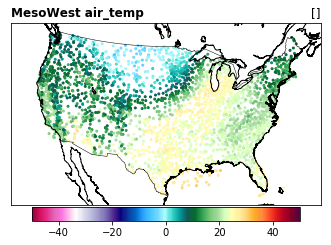

In [23]:
cmap = cm_temp()
m.scatter(a['LON'], a['LAT'], c=a['air_temp'],
          s=4,
          cmap=cmap['cmap'],
          vmax=cmap['vmax'],
          vmin=cmap['vmin'],
          latlon=True,)
plt.colorbar(orientation='horizontal', pad=.01, shrink=.8)
m.drawcoastlines()
m.drawcountries()

plt.title('MesoWest %s' % mw_variable, loc='left', fontweight='semibold');
plt.title('%s' % a['DATETIME'], loc='right');

In [56]:
# HRRR F00 value at each point
H_dic = {'value': HH[0],
         'lat': lat,
         'lon': lon,
         'valid': validDATE}
a['HRRR F00'] = np.array([pluck_hrrr_point(H_dic, lat=a['LAT'][i], lon=a['LON'][i], verbose=False)[1] for i in range(len(a['STID']))])
print("finished F00")

# HRRR F01 value at each point
H_dic = {'value': HH[1],
         'lat': lat,
         'lon': lon,
         'valid': validDATE}
a['HRRR F01'] = np.array([pluck_hrrr_point(H_dic, lat=a['LAT'][i], lon=a['LON'][i], verbose=False)[1] for i in range(len(a['STID']))])
print("finished F01")

# HRRR TLE Mean at each point
for i in range(len(forecasts)):
    H_dic = {'value': np.mean(forecasts[i]['data'], axis=0),
             'lat': lat,
             'lon': lon,
             'valid': validDATE}
    a['HRRR'+forecasts[i]['name']] = np.array([pluck_hrrr_point(H_dic, lat=a['LAT'][i], lon=a['LON'][i], verbose=False)[1] for i in range(len(a['STID']))])
    print("finished", forecasts[i]['name'])

finished F00
finished F01
finished F02 through F05
finished F06 through F12
finished F12 through F18
finished F06 through F18


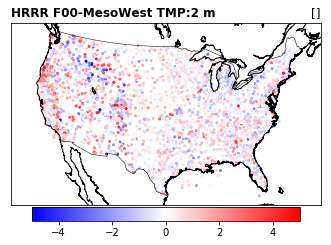

In [57]:
cmap = cm_temp()
m.scatter(a['LON'], a['LAT'], c=a['HRRR F00']-a['air_temp'],
          s=4,
          cmap='bwr',
          vmax=5,
          vmin=-5,
          latlon=True,)
plt.colorbar(orientation='horizontal', pad=.01, shrink=.8)
m.drawcoastlines()
m.drawcountries()

plt.title('HRRR F00-MesoWest %s' % variable, loc='left', fontweight='semibold');
plt.title('%s' % a['DATETIME'], loc='right');

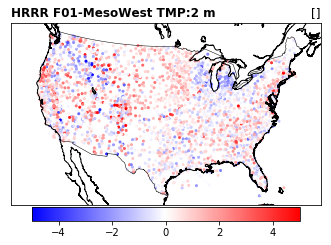

In [58]:
m.scatter(a['LON'], a['LAT'], c=a['HRRR F01']-a['air_temp'],
          s=4,
          cmap='bwr',
          vmax=5,
          vmin=-5,
          latlon=True,)
plt.colorbar(orientation='horizontal', pad=.01, shrink=.8)
m.drawcoastlines()
m.drawcountries()

plt.title('HRRR F01-MesoWest %s' % variable, loc='left', fontweight='semibold');
plt.title('%s' % a['DATETIME'], loc='right');

0.679363802931298
0.7803079137812373
0.7937469059584559
0.7880126536047363


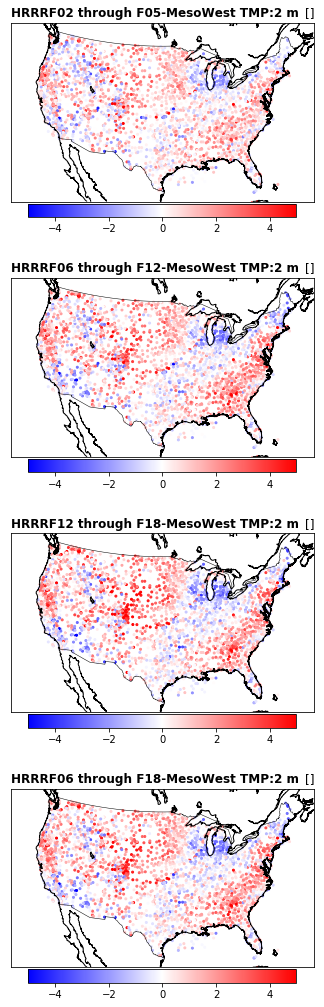

In [65]:
fig, axes = plt.subplots(4,1, figsize=(6,18))
for i in range(len(forecasts)):
    plt.sca(axes[i])
    print(np.mean(a['HRRR'+forecasts[i]['name']]-a['air_temp']))
    m.scatter(a['LON'], a['LAT'], c=a['HRRR'+forecasts[i]['name']]-a['air_temp'],
              s=4,
              cmap='bwr',
              vmax=5,
              vmin=-5,
              latlon=True,)
    plt.colorbar(orientation='horizontal', pad=.01, shrink=.8)
    m.drawcoastlines()
    m.drawcountries()

    plt.title('%s-MesoWest %s' % ('HRRR'+forecasts[i]['name'], variable), loc='left', fontweight='semibold');
    plt.title('%s' % a['DATETIME'], loc='right');

In [67]:
import this

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
